<a href="https://colab.research.google.com/github/mshilpaa/EVA4/blob/master/Session%206/l1_%3D_0_00005_l2_%3D_0_00005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


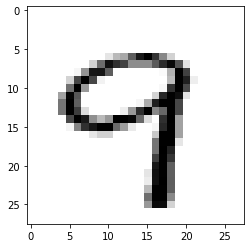

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

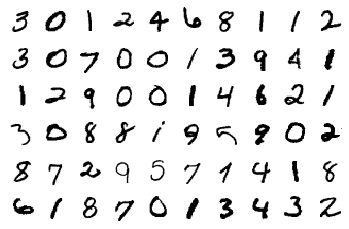

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), # i/p= 28 o/p=26 r=3
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(p=0.05),

            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), # i/p=26  o/p=24 r=5
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(p=0.05),
            
            nn.MaxPool2d(kernel_size=(2,2)), # i/p=24  o/p=12 r=6  

            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=12  o/p=10 r=10
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(p=0.05),
            

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=10  o/p=8 r=14
            nn.ReLU(),
            nn.BatchNorm2d(num_features=12),
            nn.Dropout(p=0.05),

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=8  o/p=6 r=18
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(p=0.05),

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=6  o/p=4 r=22
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(p=0.05),

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=4  o/p=2 r=26
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(p=0.05),

            nn.AdaptiveAvgPool2d(1),

            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),


        ) 

    def forward(self, x):

        x = self.convblock1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 12, 10, 10]           1,080
             ReLU-11           [-1, 12, 10, 10]               0
      BatchNorm2d-12           [-1, 12, 10, 10]              24
          Dropout-13           [-1, 12, 10, 10]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
def L1_loss(model, data, factor):
  l1_crit = nn.L1Loss().to(device)
  reg_loss = 0
  for param in model.parameters():
    zero_vector = torch.rand_like(param) * 0
    reg_loss += l1_crit(param, zero_vector)
  return factor * reg_loss

In [0]:
def misclassified_images(misclassify):
  j=0
  fig = plt.figure(figsize=(15,15)) 
  for i in range(25): 
      ax = fig.add_subplot(5,5 , 1 + j) # 4 rows, 3 columns, 1+j is the index which gives position of each image in the plot
      plt.imshow(misclassify[i][0].cpu().numpy().squeeze(), cmap='gray_r') # display the image
      title = "Predicted: "+ str(misclassify[i][1][0].data.cpu().numpy())+" Target: "+ str(misclassify[i][2].data.cpu().numpy())
      ax.set_title(title) # give the class of the image as its title
      j+=1
  plt.subplots_adjust( hspace=0.5, wspace=0.35)      
  plt.show()

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
misclassify = []

def train(model, device, train_loader, optimizer, epoch, use_l1 = False,l1_factor = 0.0005):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    if use_l1 == True:
      loss += L1_loss(model,data,factor=l1_factor)

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # output is the probability for each class
            # output look like this: [[10 values(classes)],[],... 16(batch size) lists]
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            for i in range(len(pred)):
              if pred[i] != target[i]:
                misclassify.append([data[i],pred[i],target[i]])
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    # print("o === ",pred,"-------target = ",target,"output",output.shape)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    # print(len(misclassify))
    # print(misclassify[0][0].size()) 
    test_acc.append(100. * correct / len(test_loader.dataset))

    # j=0
    # fig = plt.figure(figsize=(15,15)) 
    # for i in range(25): 
    #     ax = fig.add_subplot(7,4 , 1 + j) # 4 rows, 3 columns, 1+j is the index which gives position of each image in the plot
    #     plt.imshow(misclassify[i][0].cpu().numpy().squeeze(), cmap='gray_r') # display the image
    #     title = "predicted: "+ str(misclassify[i][1].data.cpu().numpy())+"target: "+ str(misclassify[i][2].data.cpu().numpy())
    #     ax.set_title(title) # give the class of the image as its title
    #     j+=1      
    # plt.show()

# Let's Train and test our model

In [0]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch,"lr = ",optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    misclassify = []
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 lr =  0.01


Loss=0.11745747923851013 Batch_id=468 Accuracy=91.46: 100%|██████████| 469/469 [00:11<00:00, 39.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0573, Accuracy: 9831/10000 (98.31%)

EPOCH: 1 lr =  0.01


Loss=0.11708524078130722 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:12<00:00, 38.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9862/10000 (98.62%)

EPOCH: 2 lr =  0.01


Loss=0.027206212282180786 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:11<00:00, 39.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9898/10000 (98.98%)

EPOCH: 3 lr =  0.01


Loss=0.02263178490102291 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:11<00:00, 40.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9902/10000 (99.02%)

EPOCH: 4 lr =  0.01


Loss=0.029819397255778313 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:11<00:00, 39.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9910/10000 (99.10%)

EPOCH: 5 lr =  0.01


Loss=0.007419422268867493 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:13<00:00, 35.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9907/10000 (99.07%)

EPOCH: 6 lr =  0.001


Loss=0.0314440093934536 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:12<00:00, 36.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9928/10000 (99.28%)

EPOCH: 7 lr =  0.001


Loss=0.006001005414873362 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:12<00:00, 37.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9935/10000 (99.35%)

EPOCH: 8 lr =  0.0001


Loss=0.0032568424940109253 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:12<00:00, 37.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9929/10000 (99.29%)

EPOCH: 9 lr =  0.0001


Loss=0.004313737154006958 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:12<00:00, 36.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9936/10000 (99.36%)

EPOCH: 10 lr =  0.0001


Loss=0.06350643932819366 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:12<00:00, 36.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9939/10000 (99.39%)

EPOCH: 11 lr =  0.0001


Loss=0.011869137175381184 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:12<00:00, 37.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9929/10000 (99.29%)

EPOCH: 12 lr =  1e-05


Loss=0.0938589945435524 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:12<00:00, 37.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9933/10000 (99.33%)

EPOCH: 13 lr =  1e-05


Loss=0.0031535427551716566 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 35.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9937/10000 (99.37%)

EPOCH: 14 lr =  1e-05


Loss=0.004121830221265554 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 36.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

EPOCH: 15 lr =  1e-05


Loss=0.006570776458829641 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:12<00:00, 46.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9935/10000 (99.35%)

EPOCH: 16 lr =  1e-05


Loss=0.050653982907533646 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:12<00:00, 37.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9936/10000 (99.36%)

EPOCH: 17 lr =  1e-05


Loss=0.013306066393852234 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 35.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)

EPOCH: 18 lr =  1e-05


Loss=0.04434948042035103 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 38.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9932/10000 (99.32%)

EPOCH: 19 lr =  1e-05


Loss=0.04467114806175232 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 40.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9934/10000 (99.34%)

EPOCH: 20 lr =  1e-05


Loss=0.06781075149774551 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:12<00:00, 39.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9931/10000 (99.31%)

EPOCH: 21 lr =  1e-05


Loss=0.008853535167872906 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 39.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9933/10000 (99.33%)

EPOCH: 22 lr =  1e-05


Loss=0.057050883769989014 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:12<00:00, 38.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9934/10000 (99.34%)

EPOCH: 23 lr =  1e-05


Loss=0.032228484749794006 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 39.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9927/10000 (99.27%)

EPOCH: 24 lr =  1e-05


Loss=0.03025067411363125 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 39.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9934/10000 (99.34%)

EPOCH: 25 lr =  1e-05


Loss=0.019448617473244667 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 39.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

EPOCH: 26 lr =  1e-05


Loss=0.0395854115486145 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:12<00:00, 39.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9938/10000 (99.38%)

EPOCH: 27 lr =  1e-05


Loss=0.052627623081207275 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:12<00:00, 38.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9935/10000 (99.35%)

EPOCH: 28 lr =  1e-05


Loss=0.014865572564303875 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 39.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9932/10000 (99.32%)

EPOCH: 29 lr =  1e-05


Loss=0.007338275667279959 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:11<00:00, 39.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9933/10000 (99.33%)

EPOCH: 30 lr =  1e-05


Loss=0.03878040611743927 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 38.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9934/10000 (99.34%)

EPOCH: 31 lr =  1e-05


Loss=0.012903424911201 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:12<00:00, 38.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9931/10000 (99.31%)

EPOCH: 32 lr =  1e-05


Loss=0.024173051118850708 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 39.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9935/10000 (99.35%)

EPOCH: 33 lr =  1e-05


Loss=0.0038367013912647963 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:11<00:00, 39.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9933/10000 (99.33%)

EPOCH: 34 lr =  1e-05


Loss=0.004534413572400808 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:12<00:00, 38.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9933/10000 (99.33%)

EPOCH: 35 lr =  1e-05


Loss=0.0044685653410851955 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:12<00:00, 38.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9933/10000 (99.33%)

EPOCH: 36 lr =  1e-05


Loss=0.031114384531974792 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 39.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9934/10000 (99.34%)

EPOCH: 37 lr =  1e-05


Loss=0.027243340387940407 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 38.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9934/10000 (99.34%)

EPOCH: 38 lr =  1e-05


Loss=0.015645524486899376 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 38.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9931/10000 (99.31%)

EPOCH: 39 lr =  1e-05


Loss=0.0059812613762915134 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:12<00:00, 38.55it/s]



Test set: Average loss: 0.0212, Accuracy: 9934/10000 (99.34%)



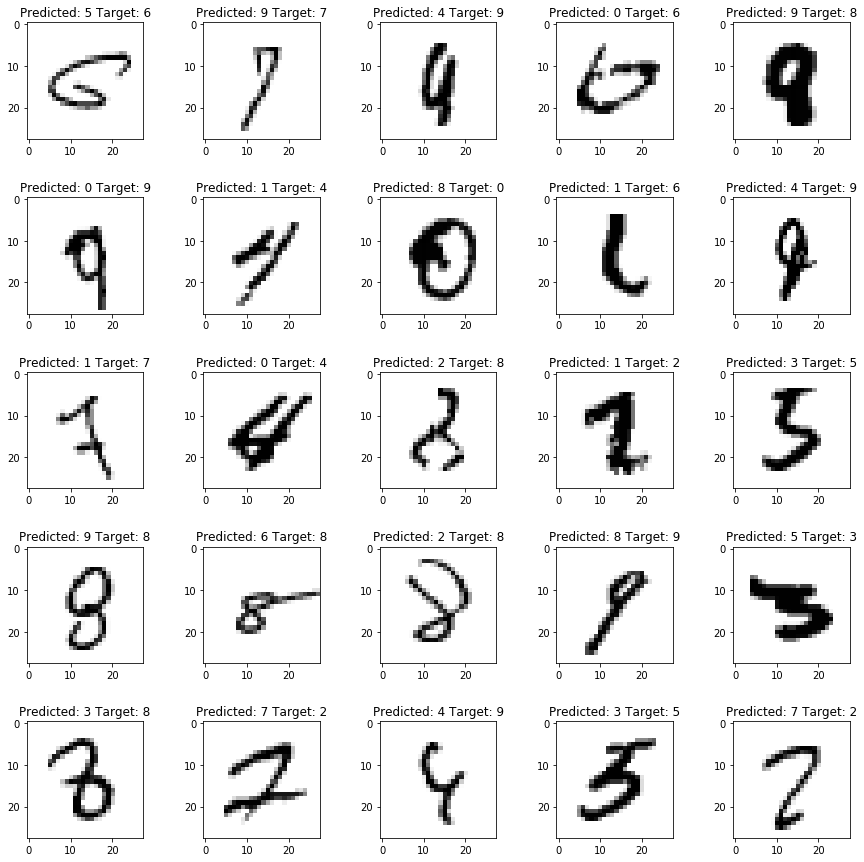

In [0]:
misclassified_images(misclassify)

In [0]:
train_acc_without_l1_l2 = train_acc.copy()
train_loss_without_l1_l2 = train_losses.copy()
test_acc_without_l1_l2 = test_acc.copy()
test_loss_without_l1_l2 = test_losses.copy()


Text(0.5, 1.0, 'Test Accuracy')

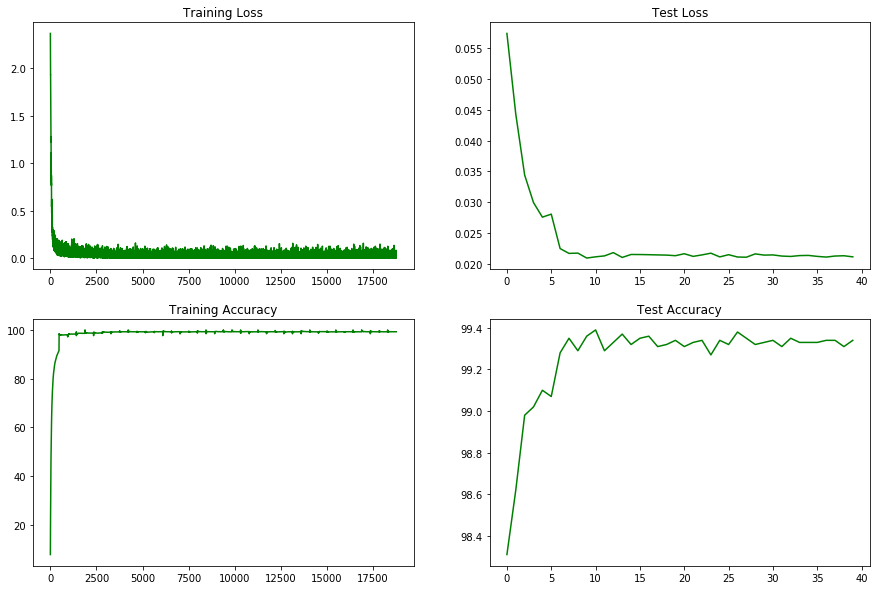

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss_without_l1_l2,color = 'g')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_without_l1_l2,color = 'g')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_loss_without_l1_l2,color = 'g')
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc_without_l1_l2,color = 'g')
axs[1, 1].set_title("Test Accuracy")

In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# **With L1**

In [0]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch,"lr = ",optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch,use_l1 = True,l1_factor=0.00005)
    scheduler.step()
    misclassify = []
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 lr =  0.01


Loss=0.07861625403165817 Batch_id=468 Accuracy=91.53: 100%|██████████| 469/469 [00:14<00:00, 32.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0718, Accuracy: 9789/10000 (97.89%)

EPOCH: 1 lr =  0.01


Loss=0.033081699162721634 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:13<00:00, 33.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Accuracy: 9854/10000 (98.54%)

EPOCH: 2 lr =  0.01


Loss=0.08197639137506485 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:14<00:00, 31.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9904/10000 (99.04%)

EPOCH: 3 lr =  0.01


Loss=0.007285513449460268 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:14<00:00, 40.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9906/10000 (99.06%)

EPOCH: 4 lr =  0.01


Loss=0.019151700660586357 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:14<00:00, 33.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9914/10000 (99.14%)

EPOCH: 5 lr =  0.01


Loss=0.07533096522092819 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:14<00:00, 32.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9915/10000 (99.15%)

EPOCH: 6 lr =  0.001


Loss=0.10323381423950195 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:14<00:00, 32.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9929/10000 (99.29%)

EPOCH: 7 lr =  0.001


Loss=0.010724134743213654 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 32.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9930/10000 (99.30%)

EPOCH: 8 lr =  0.0001


Loss=0.07247314602136612 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 33.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9928/10000 (99.28%)

EPOCH: 9 lr =  0.0001


Loss=0.006380316335707903 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:14<00:00, 33.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9923/10000 (99.23%)

EPOCH: 10 lr =  0.0001


Loss=0.006538631860166788 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9925/10000 (99.25%)

EPOCH: 11 lr =  0.0001


Loss=0.08124222606420517 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:13<00:00, 33.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9927/10000 (99.27%)

EPOCH: 12 lr =  1e-05


Loss=0.02984330803155899 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 40.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9925/10000 (99.25%)

EPOCH: 13 lr =  1e-05


Loss=0.0226606372743845 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 32.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9932/10000 (99.32%)

EPOCH: 14 lr =  1e-05


Loss=0.008033530786633492 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 41.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9924/10000 (99.24%)

EPOCH: 15 lr =  1e-05


Loss=0.1010957732796669 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:16<00:00, 28.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9928/10000 (99.28%)

EPOCH: 16 lr =  1e-05


Loss=0.008251672610640526 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 30.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9928/10000 (99.28%)

EPOCH: 17 lr =  1e-05


Loss=0.005793072748929262 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 31.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9931/10000 (99.31%)

EPOCH: 18 lr =  1e-05


Loss=0.04842732846736908 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9933/10000 (99.33%)

EPOCH: 19 lr =  1e-05


Loss=0.05997428297996521 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 31.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9930/10000 (99.30%)

EPOCH: 20 lr =  1e-05


Loss=0.02616172842681408 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 30.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9923/10000 (99.23%)

EPOCH: 21 lr =  1e-05


Loss=0.0026230113580822945 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 39.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9929/10000 (99.29%)

EPOCH: 22 lr =  1e-05


Loss=0.01035610493272543 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 31.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9926/10000 (99.26%)

EPOCH: 23 lr =  1e-05


Loss=0.09662331640720367 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 38.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9932/10000 (99.32%)

EPOCH: 24 lr =  1e-05


Loss=0.013777568936347961 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 38.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9924/10000 (99.24%)

EPOCH: 25 lr =  1e-05


Loss=0.009743588045239449 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 38.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

EPOCH: 26 lr =  1e-05


Loss=0.02457951381802559 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 31.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9924/10000 (99.24%)

EPOCH: 27 lr =  1e-05


Loss=0.044642165303230286 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 30.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9927/10000 (99.27%)

EPOCH: 28 lr =  1e-05


Loss=0.006198517512530088 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 31.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9928/10000 (99.28%)

EPOCH: 29 lr =  1e-05


Loss=0.041569869965314865 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 31.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9926/10000 (99.26%)

EPOCH: 30 lr =  1e-05


Loss=0.04322913661599159 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 31.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9930/10000 (99.30%)

EPOCH: 31 lr =  1e-05


Loss=0.07760265469551086 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:15<00:00, 31.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9930/10000 (99.30%)

EPOCH: 32 lr =  1e-05


Loss=0.01649417169392109 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 31.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9931/10000 (99.31%)

EPOCH: 33 lr =  1e-05


Loss=0.031531479209661484 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:15<00:00, 31.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9932/10000 (99.32%)

EPOCH: 34 lr =  1e-05


Loss=0.006783764809370041 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 29.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9929/10000 (99.29%)

EPOCH: 35 lr =  1e-05


Loss=0.028730206191539764 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 30.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9925/10000 (99.25%)

EPOCH: 36 lr =  1e-05


Loss=0.0025115308817476034 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 31.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9928/10000 (99.28%)

EPOCH: 37 lr =  1e-05


Loss=0.015222189016640186 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 31.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9932/10000 (99.32%)

EPOCH: 38 lr =  1e-05


Loss=0.039065875113010406 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 30.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9923/10000 (99.23%)

EPOCH: 39 lr =  1e-05


Loss=0.007604031823575497 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 31.85it/s]



Test set: Average loss: 0.0207, Accuracy: 9923/10000 (99.23%)



In [0]:
len(misclassify)

77

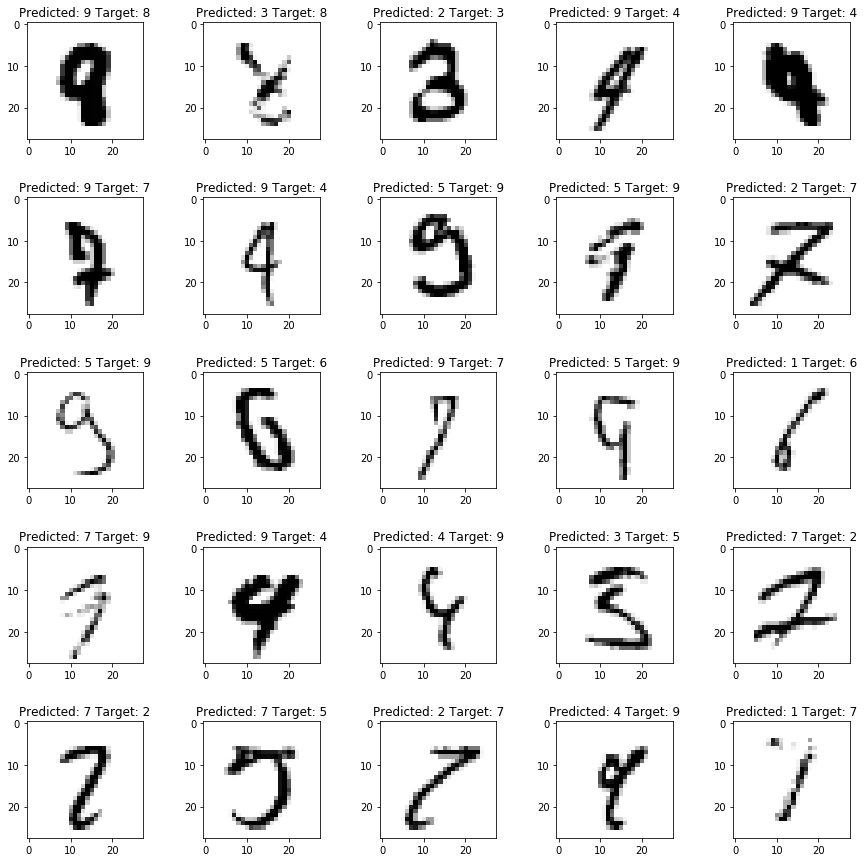

In [0]:
misclassified_images(misclassify)

In [0]:
train_acc_with_l1 = train_acc.copy()
train_loss_with_l1 = train_losses.copy()
test_acc_with_l1 = test_acc.copy()
test_loss_with_l1 = test_losses.copy()

Text(0.5, 1.0, 'Test Accuracy')

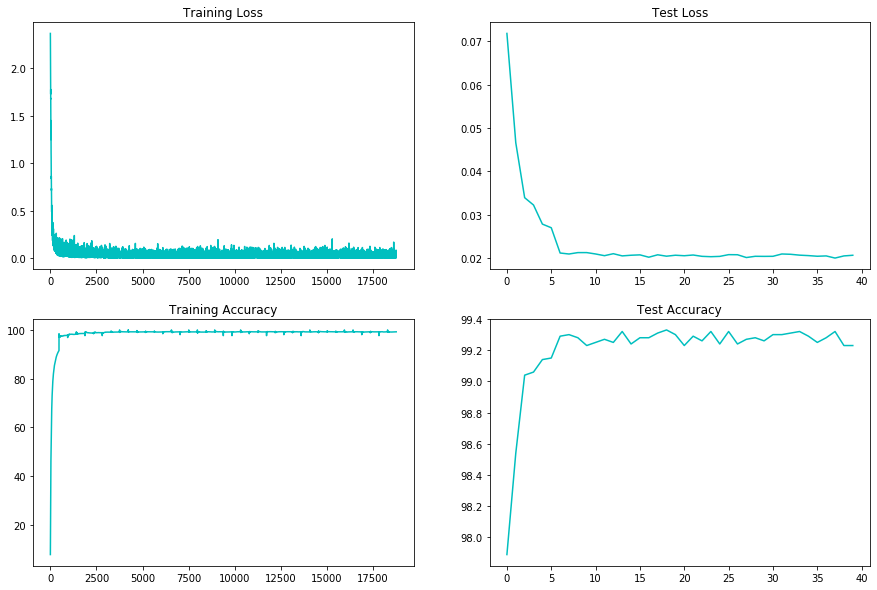

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss_with_l1,color='c')
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc_with_l1,color='c')

axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_loss_with_l1,color='c')

axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc_with_l1,color='c')

axs[1, 1].set_title("Test Accuracy")

In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# **With L2**

In [0]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.00005)
scheduler = MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch,"lr = ",optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    misclassify = []
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 lr =  0.01


Loss=0.102894626557827 Batch_id=468 Accuracy=90.17: 100%|██████████| 469/469 [00:12<00:00, 36.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0640, Accuracy: 9815/10000 (98.15%)

EPOCH: 1 lr =  0.01


Loss=0.10452977567911148 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:13<00:00, 34.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0479, Accuracy: 9862/10000 (98.62%)

EPOCH: 2 lr =  0.01


Loss=0.0859886035323143 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:13<00:00, 35.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 9890/10000 (98.90%)

EPOCH: 3 lr =  0.01


Loss=0.028294390067458153 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:12<00:00, 36.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9893/10000 (98.93%)

EPOCH: 4 lr =  0.01


Loss=0.07150521129369736 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:12<00:00, 37.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9901/10000 (99.01%)

EPOCH: 5 lr =  0.01


Loss=0.04907770827412605 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:12<00:00, 43.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9933/10000 (99.33%)

EPOCH: 6 lr =  0.001


Loss=0.020224830135703087 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 35.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9936/10000 (99.36%)

EPOCH: 7 lr =  0.001


Loss=0.02173878438770771 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:12<00:00, 36.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9936/10000 (99.36%)

EPOCH: 8 lr =  0.0001


Loss=0.0136689692735672 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:12<00:00, 36.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9939/10000 (99.39%)

EPOCH: 9 lr =  0.0001


Loss=0.05249295011162758 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 35.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9939/10000 (99.39%)

EPOCH: 10 lr =  0.0001


Loss=0.027323471382260323 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:12<00:00, 36.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9937/10000 (99.37%)

EPOCH: 11 lr =  0.0001


Loss=0.06514836102724075 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:12<00:00, 36.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9939/10000 (99.39%)

EPOCH: 12 lr =  1e-05


Loss=0.04084787890315056 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:12<00:00, 36.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9936/10000 (99.36%)

EPOCH: 13 lr =  1e-05


Loss=0.007917526178061962 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 35.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9936/10000 (99.36%)

EPOCH: 14 lr =  1e-05


Loss=0.0419645719230175 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 35.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9938/10000 (99.38%)

EPOCH: 15 lr =  1e-05


Loss=0.018295103684067726 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:12<00:00, 37.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9938/10000 (99.38%)

EPOCH: 16 lr =  1e-05


Loss=0.060609180480241776 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:12<00:00, 36.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9937/10000 (99.37%)

EPOCH: 17 lr =  1e-05


Loss=0.023914271965622902 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:13<00:00, 35.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9939/10000 (99.39%)

EPOCH: 18 lr =  1e-05


Loss=0.09943047165870667 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 39.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9938/10000 (99.38%)

EPOCH: 19 lr =  1e-05


Loss=0.0046343556605279446 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 34.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9938/10000 (99.38%)

EPOCH: 20 lr =  1e-05


Loss=0.016801565885543823 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 34.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9937/10000 (99.37%)

EPOCH: 21 lr =  1e-05


Loss=0.04335366562008858 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:13<00:00, 34.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9937/10000 (99.37%)

EPOCH: 22 lr =  1e-05


Loss=0.0024560343008488417 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:12<00:00, 36.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9940/10000 (99.40%)

EPOCH: 23 lr =  1e-05


Loss=0.028109610080718994 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:12<00:00, 36.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9937/10000 (99.37%)

EPOCH: 24 lr =  1e-05


Loss=0.013706356287002563 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 35.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9939/10000 (99.39%)

EPOCH: 25 lr =  1e-05


Loss=0.03492376580834389 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 35.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9936/10000 (99.36%)

EPOCH: 26 lr =  1e-05


Loss=0.007154782768338919 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:12<00:00, 36.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9938/10000 (99.38%)

EPOCH: 27 lr =  1e-05


Loss=0.029397359117865562 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:12<00:00, 40.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9937/10000 (99.37%)

EPOCH: 28 lr =  1e-05


Loss=0.005559419747442007 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:12<00:00, 45.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9940/10000 (99.40%)

EPOCH: 29 lr =  1e-05


Loss=0.052431393414735794 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 35.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9939/10000 (99.39%)

EPOCH: 30 lr =  1e-05


Loss=0.008030802011489868 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:12<00:00, 36.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9938/10000 (99.38%)

EPOCH: 31 lr =  1e-05


Loss=0.0076401084661483765 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:12<00:00, 36.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9939/10000 (99.39%)

EPOCH: 32 lr =  1e-05


Loss=0.021693339571356773 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 35.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9939/10000 (99.39%)

EPOCH: 33 lr =  1e-05


Loss=0.01531424093991518 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 35.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9937/10000 (99.37%)

EPOCH: 34 lr =  1e-05


Loss=0.13995924592018127 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:13<00:00, 35.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9937/10000 (99.37%)

EPOCH: 35 lr =  1e-05


Loss=0.004299059510231018 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:12<00:00, 36.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9938/10000 (99.38%)

EPOCH: 36 lr =  1e-05


Loss=0.01555031817406416 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 35.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9938/10000 (99.38%)

EPOCH: 37 lr =  1e-05


Loss=0.11647605895996094 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 35.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9937/10000 (99.37%)

EPOCH: 38 lr =  1e-05


Loss=0.0064408727921545506 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 36.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9937/10000 (99.37%)

EPOCH: 39 lr =  1e-05


Loss=0.009779726155102253 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:12<00:00, 36.17it/s]



Test set: Average loss: 0.0224, Accuracy: 9939/10000 (99.39%)



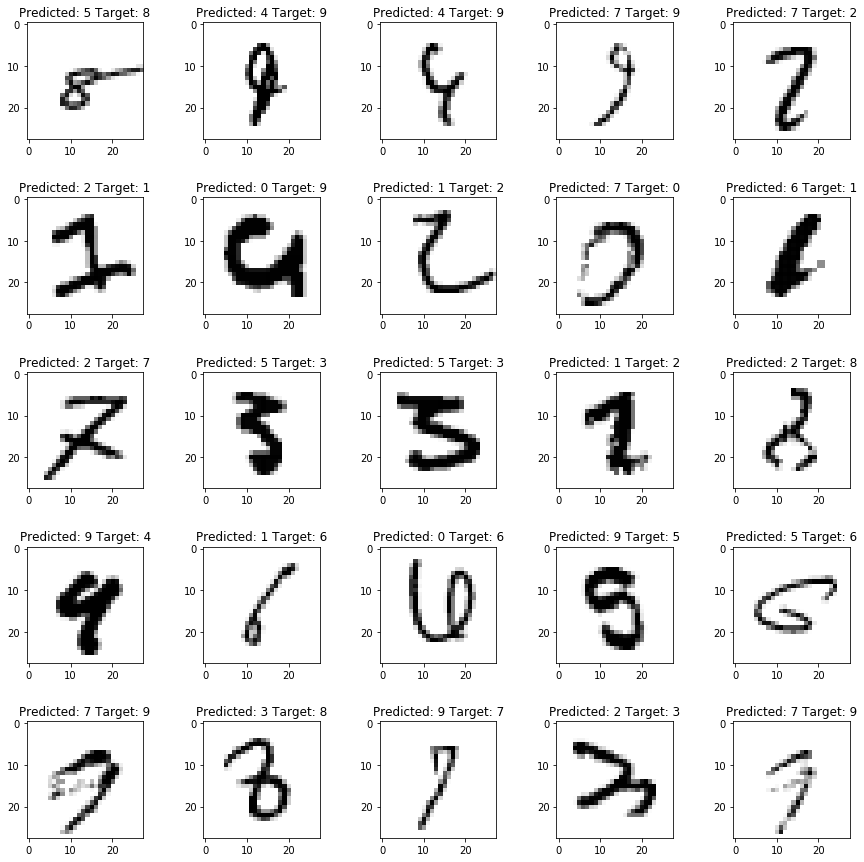

In [0]:
misclassified_images(misclassify)

In [0]:
train_acc_with_l2 = train_acc.copy()
train_loss_with_l2 = train_losses.copy()
test_acc_with_l2 = test_acc.copy()
test_loss_with_l2 = test_losses.copy()


Text(0.5, 1.0, 'Test Accuracy')

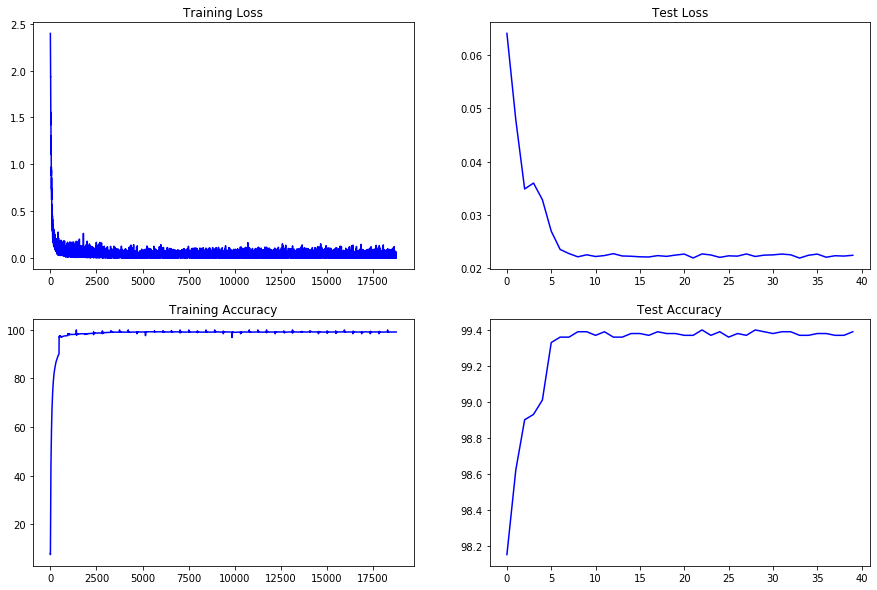

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_loss_with_l2,color = 'b')

axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc_with_l2,color = 'b')

axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_loss_with_l2,color = 'b')

axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc_with_l2,color = 'b')

axs[1, 1].set_title("Test Accuracy")

In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# **With L1 and L2**

In [0]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.00005)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch,"lr = ",optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch, use_l1 = True,l1_factor=0.00005)
    scheduler.step()
    misclassify = []
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 lr =  0.01


Loss=0.06949260830879211 Batch_id=468 Accuracy=91.26: 100%|██████████| 469/469 [00:16<00:00, 29.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0614, Accuracy: 9840/10000 (98.40%)

EPOCH: 1 lr =  0.01


Loss=0.04004853218793869 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:16<00:00, 29.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9853/10000 (98.53%)

EPOCH: 2 lr =  0.01


Loss=0.022737788036465645 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:15<00:00, 38.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9888/10000 (98.88%)

EPOCH: 3 lr =  0.01


Loss=0.010779683478176594 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:16<00:00, 28.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9891/10000 (98.91%)

EPOCH: 4 lr =  0.01


Loss=0.02931942604482174 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:15<00:00, 29.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9909/10000 (99.09%)

EPOCH: 5 lr =  0.01


Loss=0.07569345831871033 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:15<00:00, 29.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9896/10000 (98.96%)

EPOCH: 6 lr =  0.001


Loss=0.008606290444731712 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:16<00:00, 29.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9920/10000 (99.20%)

EPOCH: 7 lr =  0.001


Loss=0.013619177043437958 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:16<00:00, 28.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9923/10000 (99.23%)

EPOCH: 8 lr =  0.0001


Loss=0.025990290567278862 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:15<00:00, 29.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9921/10000 (99.21%)

EPOCH: 9 lr =  0.0001


Loss=0.011693250387907028 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 29.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9925/10000 (99.25%)

EPOCH: 10 lr =  0.0001


Loss=0.05575670301914215 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:15<00:00, 29.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9924/10000 (99.24%)

EPOCH: 11 lr =  0.0001


Loss=0.01481552328914404 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 30.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9925/10000 (99.25%)

EPOCH: 12 lr =  1e-05


Loss=0.04038618505001068 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 39.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9922/10000 (99.22%)

EPOCH: 13 lr =  1e-05


Loss=0.030390696600079536 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 38.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9922/10000 (99.22%)

EPOCH: 14 lr =  1e-05


Loss=0.03690914064645767 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 31.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9923/10000 (99.23%)

EPOCH: 15 lr =  1e-05


Loss=0.021488528698682785 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 31.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9926/10000 (99.26%)

EPOCH: 16 lr =  1e-05


Loss=0.011711182072758675 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 36.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9922/10000 (99.22%)

EPOCH: 17 lr =  1e-05


Loss=0.007135156542062759 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 30.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9925/10000 (99.25%)

EPOCH: 18 lr =  1e-05


Loss=0.018115317448973656 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:15<00:00, 30.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9922/10000 (99.22%)

EPOCH: 19 lr =  1e-05


Loss=0.03180548921227455 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:15<00:00, 30.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9925/10000 (99.25%)

EPOCH: 20 lr =  1e-05


Loss=0.023906374350190163 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 30.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9927/10000 (99.27%)

EPOCH: 21 lr =  1e-05


Loss=0.025181056931614876 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 30.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9922/10000 (99.22%)

EPOCH: 22 lr =  1e-05


Loss=0.0023569248151034117 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 30.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9921/10000 (99.21%)

EPOCH: 23 lr =  1e-05


Loss=0.039448726922273636 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 30.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9926/10000 (99.26%)

EPOCH: 24 lr =  1e-05


Loss=0.01866653375327587 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:15<00:00, 30.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9923/10000 (99.23%)

EPOCH: 25 lr =  1e-05


Loss=0.015038401819765568 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 30.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9926/10000 (99.26%)

EPOCH: 26 lr =  1e-05


Loss=0.04450135678052902 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:15<00:00, 30.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9923/10000 (99.23%)

EPOCH: 27 lr =  1e-05


Loss=0.011855087243020535 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 30.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9924/10000 (99.24%)

EPOCH: 28 lr =  1e-05


Loss=0.027079904451966286 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 31.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9924/10000 (99.24%)

EPOCH: 29 lr =  1e-05


Loss=0.1301315575838089 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:15<00:00, 31.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9921/10000 (99.21%)

EPOCH: 30 lr =  1e-05


Loss=0.06534461677074432 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 30.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9922/10000 (99.22%)

EPOCH: 31 lr =  1e-05


Loss=0.01433754712343216 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 30.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9924/10000 (99.24%)

EPOCH: 32 lr =  1e-05


Loss=0.029802946373820305 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 30.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9926/10000 (99.26%)

EPOCH: 33 lr =  1e-05


Loss=0.013176598586142063 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 30.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9927/10000 (99.27%)

EPOCH: 34 lr =  1e-05


Loss=0.020416850224137306 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 30.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9925/10000 (99.25%)

EPOCH: 35 lr =  1e-05


Loss=0.03530729189515114 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 38.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9922/10000 (99.22%)

EPOCH: 36 lr =  1e-05


Loss=0.008134991861879826 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:14<00:00, 31.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9922/10000 (99.22%)

EPOCH: 37 lr =  1e-05


Loss=0.007141115143895149 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 30.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9923/10000 (99.23%)

EPOCH: 38 lr =  1e-05


Loss=0.017640836536884308 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 30.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9922/10000 (99.22%)

EPOCH: 39 lr =  1e-05


Loss=0.010153799317777157 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:15<00:00, 30.70it/s]



Test set: Average loss: 0.0255, Accuracy: 9921/10000 (99.21%)



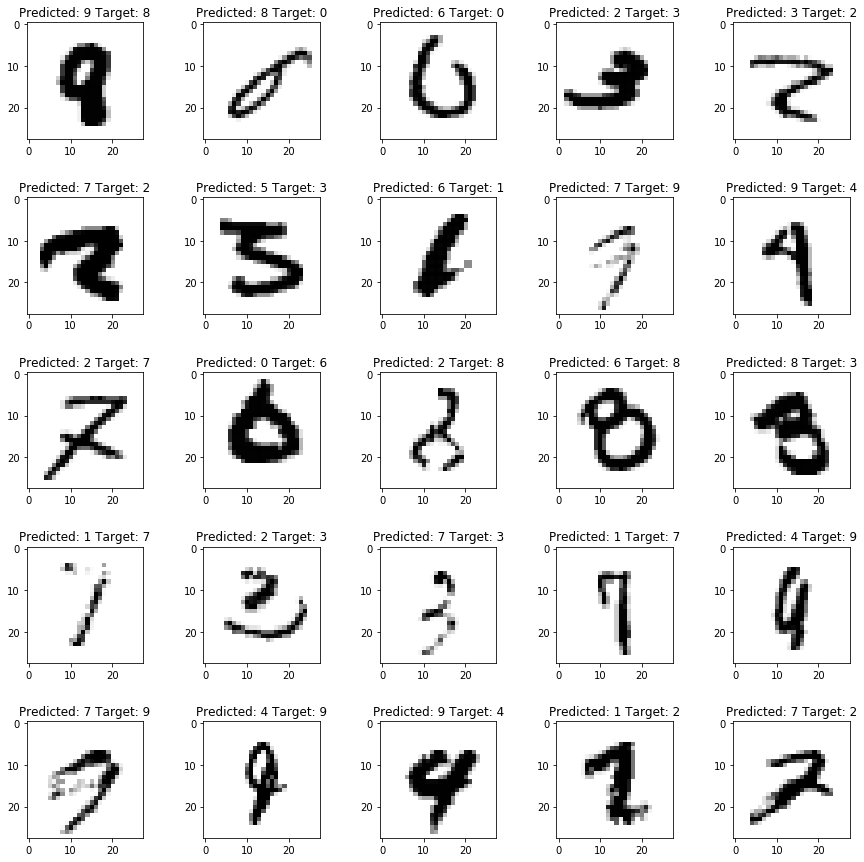

In [0]:
misclassified_images(misclassify)

In [0]:
train_acc_with_l1_l2 = train_acc.copy()
train_loss_with_l1_l2 = train_losses.copy()
test_acc_with_l1_l2 = test_acc.copy()
test_loss_with_l1_l2 = test_losses.copy()

Text(0.5, 1.0, 'Test Accuracy')

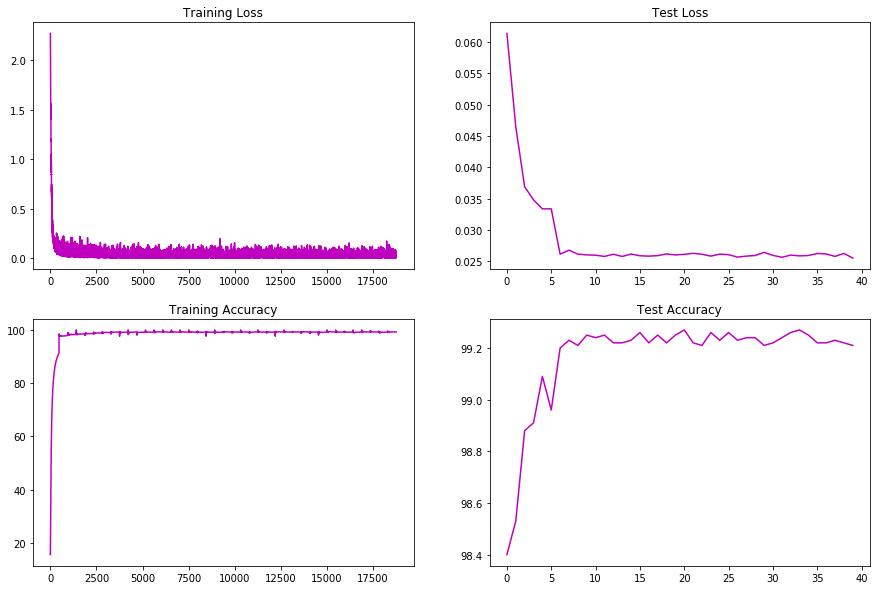

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_loss_with_l1_l2,color = 'm')

axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc_with_l1_l2,color = 'm')

axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_loss_with_l1_l2,color = 'm')

axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc_with_l1_l2,color = 'm')

axs[1, 1].set_title("Test Accuracy")

Text(0.5, 0.98, 'l1 = 0.00005, l2 = 0.00005')

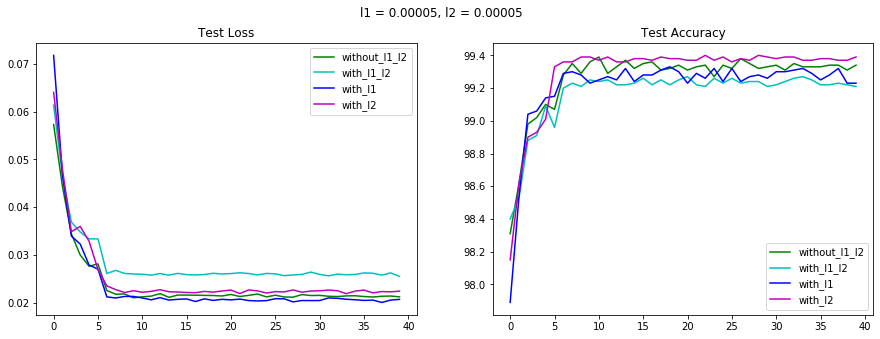

In [0]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(test_loss_without_l1_l2,color = 'g',label="without_l1_l2")
axs[0].plot(test_loss_with_l1_l2,color = 'c',label="with_l1_l2")
axs[0].plot(test_loss_with_l1,color = 'b',label="with_l1")
axs[0].plot(test_loss_with_l2,color = 'm',label="with_l2")
axs[0].set_title("Test Loss")
axs[0].legend()
axs[1].plot(test_acc_without_l1_l2,color = 'g',label="without_l1_l2")
axs[1].plot(test_acc_with_l1_l2,color = 'c',label="with_l1_l2")
axs[1].plot(test_acc_with_l1,color = 'b',label="with_l1")
axs[1].plot(test_acc_with_l2,color = 'm',label="with_l2")
axs[1].set_title("Test Accuracy")
axs[1].legend()
fig.suptitle("l1 = 0.00005, l2 = 0.00005")